In [1]:
import matplotlib.pyplot as plt
import mplhep
import numpy as np
import pandas as pd
import scipy.optimize as sc
import scipy

In [80]:
file_CCl4 = 'CCD/CCl4_spectrum_2.txt'
file_back = 'CCD/manual_background_1.txt'

df_CCl4 = pd.read_csv(file_CCl4, skiprows=17, skipfooter=1, sep='\t', names=['Channel', 'Counts'], decimal=',')
df_back = pd.read_csv(file_back, skiprows=17, skipfooter=1, sep='\t', names=['Channel', 'Counts'], decimal=',')

# print(df['Channel'])

<ipython-input-80-c88ecdd32b90>:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df_CCl4 = pd.read_csv(file_CCl4, skiprows=17, skipfooter=1, sep='\t', names=['Channel', 'Counts'], decimal=',')
<ipython-input-80-c88ecdd32b90>:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df_back = pd.read_csv(file_back, skiprows=17, skipfooter=1, sep='\t', names=['Channel', 'Counts'], decimal=',')


In [107]:
def lorentz(x, A, w0, gamma, C):
    '''Function of a Lorentz-curve.

    w0 : position of maximum
    gamma : curve width
    '''
    return A/((x**2 - w0**2)**2 + gamma**2 * w0**2) + C


def voigt(x, mean, sigma, gamma, A, c):
    return A * scipy.special.voigt_profile(x-mean, sigma, gamma) + c

def gauss(x, A, mu, sigma, C):
    return A * np.exp(-(x-mu)**2 / (2*sigma**2)) + C

def doppel_gauss(x, A1, mu1, sigma1, A2, mu2, sigma2, C):
    return (A1 * np.exp(-(x-mu1)**2 / (2*sigma1**2)) + A2 * np.exp(-(x-mu2)**2 / (2*sigma2**2))) + C

In [0]:
fig, ax = plt.subplots(figsize = (12,8))
y_counts = df_CCl4['Counts'] # - df_back['Counts']
ax.plot(df_CCl4['Channel'], y_counts, marker = 'x', lw=0.5, ms = 5)
coefficients = np.zeros((5, 4))
covariance = np.zeros((5, 4, 4))

a = [[820, 850], [915, 925], [950, 965], [1130, 1153], [1179, 1200], [1270, 1320]]
p0s = [[1000, 510.5, 1, 1000, 511.5, 1, 0], [5000, 519, 1, 0], [30000, 525, 1, 0],
       [60000, 541, 1, 0], [20000, 545, 1, 0], [20000, 554.3, 1, 20000, 555.3, 1, 0]]
xaxis = [np.linspace(509, 513, 1001), np.linspace(518.5, 520, 1001), np.linspace(522, 525 ,1001),
         np.linspace(540, 541.8, 1001), np.linspace(544,547,1001), np.linspace(553, 557, 1001)]
colors = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']
for i in range(1,5):
    if i==2:
        function = gauss
    else:
        function = gauss

    params, cov = sc.curve_fit(function, df_CCl4['Channel'][a[i][0]:a[i][1]], y_counts[a[i][0]:a[i][1]],
                              p0 = p0s[i])
    coefficients[i] = params
    covariance[i] = cov
    print(params, np.sqrt(np.diag(cov)))
    ax.axvline(df_CCl4['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
    ax.axvline(df_CCl4['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    ax.plot(xaxis[i], function(xaxis[i], *params), color=colors[i], label = r'$\mu = {:.1f} \,$nm'.format(params[1]))

for i in [0, 5]:
    params, cov = sc.curve_fit(doppel_gauss, df_CCl4['Channel'][a[i][0]:a[i][1]], y_counts[a[i][0]:a[i][1]],
                                  p0 = p0s[i])
    ax.axvline(df_CCl4['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
    ax.axvline(df_CCl4['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    ax.plot(xaxis[i], doppel_gauss(xaxis[i], *params), color=colors[i], label = r'$\mu1 = {:.1f} \,$nm, $\mu2 = {:.1f}\,$nm'.format(params[1], params[4]))

ax.set_xlabel(r'Wavelength [nm]')
ax.set_ylabel(r'Counts')
ax.set_title(r'CCl4 spectrum, CCD measurement')
ax.legend()
ax.set_xlim([505, 570])
# ax.set_xlim([542, 550])  # second peak
# ax.set_xlim([575, 580])
# ax.set_ylim([0, 2000])
plt.tight_layout()
plt.show()

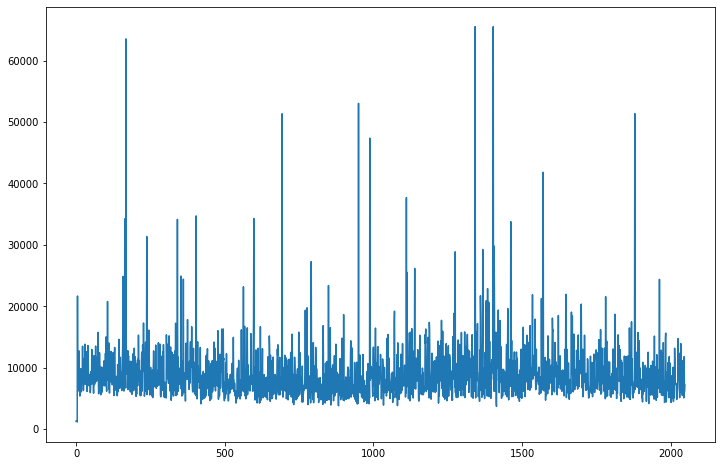

In [65]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(df_back['Counts'])
plt.show()

In [80]:
Hg_Nist = [435.8328, 546.0735, 576.9598, 579.0663]
for i in range(4):
    print('Fit:', coefficients[i,1], r'+-', np.sqrt(covariance[i,1,1]))
    print('Nist', Hg_Nist[i])
print('\n Our CCD is slightly (approx 0.2nm) shifted down.')

Fit: 435.41309729591734 +- 0.014385148755535395
Nist 435.8328
Fit: 545.8258491117172 +- 0.013390180001561345
Nist 546.0735
Fit: 576.7065044754747 +- 0.0038577954665836626
Nist 576.9598
Fit: 578.8135808545674 +- 0.003993891521947161
Nist 579.0663

 Our CCD is slightly (approx 0.2nm) shifted down.
